# Stroke Prediction Models

In [1]:
#Import DataFrame from Data-Cleaning-Notebook
import pickle
import pandas as pd
import numpy as np
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")


infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()


In [2]:
#Various imports for metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, recall_score

In [3]:
#Function to print out metrics nicely
def evaluation_report(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    plot_confusion_matrix(model, X, y, cmap='GnBu')

In [4]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi_cat
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1,obese
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,unknown
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1,obese
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1,obese
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,normal


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
#Split data into training and test serts
X = df.drop(['stroke'], axis = 1)
y = df.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Model 1 - First Simple Model

For our models, we will be focusing on the recall score. In order best assist doctors and hospitals, we want to mitigate the false negatives meaning that we do not want to identify those who are stroke victims as those who didn't. 

Recall works best for this. 

We need a starting baseline model to compare our future models to and so we used a Dummy Classifier which will always predict 0 - no stroke.

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [8]:
# View the most frequent
df.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [9]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent',).fit(X_train, y_train,)
dummy_pred = dummy.predict(X_test)

In [10]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))

Test Accuracy score:  0.9374021909233177


High accuracy but doesn't necessarily mean a great score. Because of the class imbalance, we'll get mostly all patients who didn't have strokes correct and get all the patients that had strokes incorrect as seen in the recall below.

In [11]:
# checking recall
print('Test Recall score: ', recall_score(y_test, dummy_pred))

Test Recall score:  0.0


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



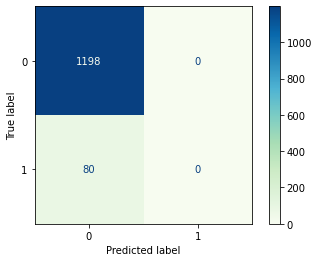

In [12]:
evaluation_report(dummy, X_test, y_test)

Many correctly predicted true negatives but at the same time, all true positives were predicted incorrectly. In context, all true stroke victimins were predicted to not have a stroke. **NOT GOOD!**

#### Model 2 - Logistic Regression: No Penalty / Without Oversampling

Create a model with different parameters and without including oversampling.

In [13]:
# Import proper libraries
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 4000 to 860
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3831 non-null   object 
 1   age                3831 non-null   float64
 2   hypertension       3831 non-null   int64  
 3   heart_disease      3831 non-null   int64  
 4   ever_married       3831 non-null   object 
 5   work_type          3831 non-null   object 
 6   Residence_type     3831 non-null   object 
 7   avg_glucose_level  3831 non-null   float64
 8   smoking_status     3831 non-null   object 
 9   bmi_cat            3831 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 329.2+ KB


In [15]:
#Get proper columns for their appropriate transformations. 
X_train_nums = X_train.select_dtypes(['float64'])
X_train_cat = X_train.select_dtypes(exclude = ['float64'])

In [16]:
from sklearn.compose import ColumnTransformer

In [17]:
# Create pipelines to ease the process.

    #Numerical pipeline to normalize the numerical columns
numerical_pipeline = Pipeline(steps=[
                                ('ss', StandardScaler())
                            ])

    #Categorical pipeline to one hot encode categorical columns
categorical_pipeline = Pipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False))
                            ])

    #Combine both pipelines into a column transformer for efficient 
        #modeling and ensure no data leakage
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [18]:
#Logistic regression with no penalty and max iteration as 1000
log_reg_no_pen_pipe = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(penalty = 'none', max_iter = 1000))
])

In [19]:
#Fit transform
log_reg_no_pen_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=1000, penalty='none'))])

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.20      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.57      0.50      0.49      1278
weighted avg       0.89      0.94      0.91      1278



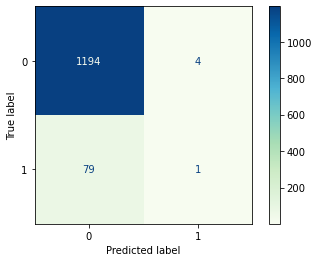

In [20]:
evaluation_report(log_reg_no_pen_pipe, X_test, y_test)

Barely better than our dummy classifier. Time to address the class imbalance. Since we have less than tens of thousands of observations, we decided to oversample the minority class using SMOTE. 

#### Model 3 - Over sample then Logistic Regression

In [21]:
#Import imbalanced learning smote and pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [22]:
#Had to use the Pipeline from imbalanced learning because SMOTE didn't
    #seem to work with skLearn's pipeline. Same idea as above. Numerical
    #pipeline for numerical columns, categorical pipeline for categorical
    #columns and one column transformer to fit and transform both
    #pipelines.

numerical_pipeline = imbpipeline(steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False))
                            ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [23]:
#First transform the data
#Then upsample the data using SMOTE
#Then do the modeling process
log_reg_scaled_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('lr', LogisticRegression(max_iter = 10000))
])

In [24]:
# Fit transform our model 
log_reg_scaled_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()), ('lr', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.98      0.76      0.85      1198
           1       0.16      0.71      0.27        80

    accuracy                           0.75      1278
   macro avg       0.57      0.73      0.56      1278
weighted avg       0.92      0.75      0.82      1278



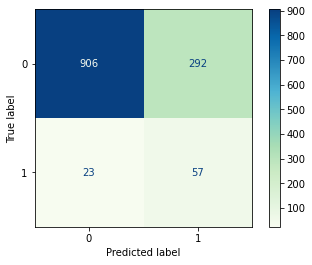

In [25]:
evaluation_report(log_reg_scaled_pipe, X_test, y_test)

With our transformations, SMOTE, and Logistic Regression with Regularization, we were able to achieve a better recall score than the two previous models. 

#### Model 4 - Logistic Regression with Polynomial Features

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
#Lets try the same model as above but include 
    #polynomial features within it
logreg_poly2_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('pf', PolynomialFeatures(2, include_bias = False)),
    ('lr', LogisticRegression(max_iter = 10000))
])

logreg_poly2_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()), ('pf', PolynomialFeatures(include_bias=False)),
                ('lr'

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1198
           1       0.18      0.41      0.25        80

    accuracy                           0.84      1278
   macro avg       0.57      0.64      0.58      1278
weighted avg       0.91      0.84      0.87      1278



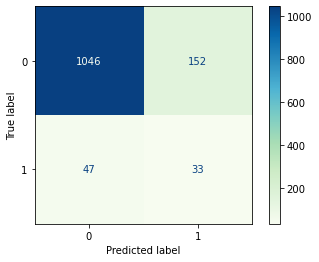

In [28]:
evaluation_report(logreg_poly2_pipe, X_test, y_test)

So that wasn't a great idea. We got a lower recall score meaning that more false negatives and in turn meaning more falsely identified stroke victims. 

#### Model 5 - Voting Classifier with LogReg/DT/KNN

Next we wanted to try default parameters for all three logistic regression, KNN Classifier, and the Decision Tree Classifier. We wanted the model to train on an ensemble of various models and hope for a better recall_score output. 

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [30]:
#Use trasnformer and smote along with 
    #Voting Classifier with LR, KNN, & Decision Trees.
steps=[ ('trans', trans),
        ('sm', SMOTE()),
        ('vc',VotingClassifier(
                estimators=[('logreg', LogisticRegression(max_iter = 10000)), 
                            ('knneighbors', KNeighborsClassifier()), 
                            ('decisiontree', DecisionTreeClassifier())], 
                voting='hard'))]
vc_pipe = imbpipeline(steps = steps)

In [31]:
vc_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()),
                ('vc',
                 VotingClassifier(estimators=[

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1198
           1       0.19      0.44      0.27        80

    accuracy                           0.85      1278
   macro avg       0.58      0.66      0.59      1278
weighted avg       0.91      0.85      0.88      1278



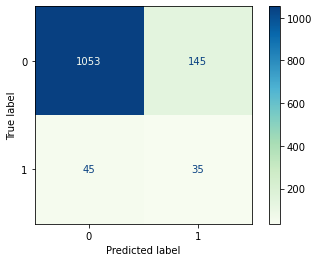

In [32]:
evaluation_report(vc_pipe, X_test, y_test)

And it does about the same as the polynomial feature logistic regression. So lets try to optimize parameters and see how well we can do using GridSearch. 

#### Model 6 - GridSearchCV: KNN

First, we wanted to find the best parameters using GridSearch with KNN and then see how it does on the training as well as the test set with the best parameters. 

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
#As always, the regular pipeline + KNN 
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('clf', KNeighborsClassifier())]

knn_cv_pipe = imbpipeline(steps=steps)

# Set of parameters we want to search through
parameters = {
    'clf__n_neighbors': range(10, 200, 10),
    'clf__metric': ['minkowski', 'manhattan'],
    'clf__weights': ['uniform', 'distance'],
}

cv = GridSearchCV(knn_cv_pipe, param_grid=parameters, scoring='recall')
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

Best parameters was a combination of metric as minkowski, n_neighbors as 190, and the class weights as uniform.

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      3662
           1       0.11      0.88      0.20       169

    accuracy                           0.70      3831
   macro avg       0.55      0.78      0.51      3831
weighted avg       0.95      0.70      0.79      3831



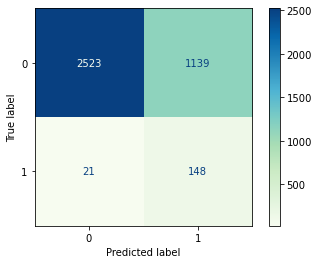

In [35]:
evaluation_report(cv.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.80      0.25        80

    accuracy                           0.70      1278
   macro avg       0.56      0.74      0.53      1278
weighted avg       0.93      0.70      0.77      1278



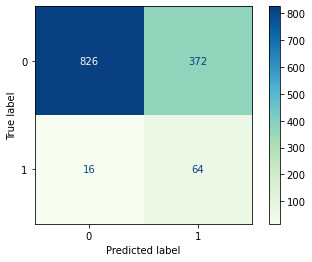

In [36]:
evaluation_report(cv, X_test, y_test)

The model performed extremely well on the training set but didn't perform as well on the test set. Could be a little over fit but we can probably do better. 

#### Model 7 - Bagging Classifier

Try out the Bagging Classifier ((This point we were trying to find a good model to really build out))

In [37]:
from sklearn.ensemble import BaggingClassifier

In [38]:
#View the params 
BaggingClassifier().get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [39]:
#Use bagging classifier with pretty much default parameters
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced'), 
            n_estimators= 100,
            max_samples= 0.8,
            max_features= 7,
            oob_score= True
                ))]
bag_pipe = imbpipeline(steps=steps)
bag_pipe.fit(X_train, y_train)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()),
                ('bag',
                 BaggingClassifier(base_estim

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1198
           1       0.21      0.64      0.32        80

    accuracy                           0.83      1278
   macro avg       0.59      0.74      0.61      1278
weighted avg       0.92      0.83      0.86      1278



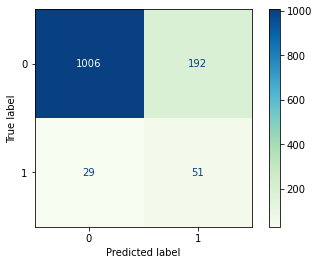

In [40]:
evaluation_report(bag_pipe, X_test, y_test)

Poor results, a recall using .64, lets use bagging + gridsearch

#### Model 8 - Bagging + Gridsearch

In [41]:
#Find the best parameters for the BaggingClassifer using Gridsearch. 
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced')))]

bag_pipe = imbpipeline(steps=steps)
params = {
    'bag__n_estimators': range(10,50,10),
    'bag__max_samples': [.3,.4,.5,.6,.7,.8],
    'bag__max_features': [1,18,1]
}
cv_bag = GridSearchCV(bag_pipe, param_grid=params, scoring='recall')
cv_bag.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3662
           1       0.15      0.86      0.26       169

    accuracy                           0.78      3831
   macro avg       0.57      0.82      0.57      3831
weighted avg       0.96      0.78      0.85      3831



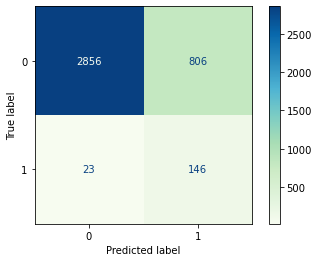

In [43]:
evaluation_report(cv_bag, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1198
           1       0.18      0.74      0.29        80

    accuracy                           0.77      1278
   macro avg       0.58      0.75      0.57      1278
weighted avg       0.93      0.77      0.83      1278



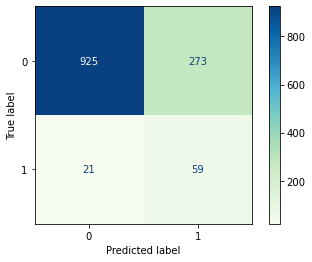

In [44]:
evaluation_report(cv_bag, X_test, y_test)

In [86]:
#The best params for Gridsearch + BaggingClassifier 
cv_bag.best_params_

{'bag__base_estimator__max_depth': 40,
 'bag__max_features': 18,
 'bag__max_samples': 0.25,
 'bag__n_estimators': 11}

The Bagging + GS model performed well on the training set, but the test set didn't have similar results. The model could be overfit on the training data.

#### Model 9 - 

Use the best params from the previous model and see if we can tune it any more by checking the edges of the parameters

In [87]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced')))]

bag_pipe = imbpipeline(steps=steps)
params = {
    'bag__n_estimators': range(10,13,1),
    'bag__max_samples': [.25,.3,.35],
    'bag__max_features': [17,18],
    'bag__base_estimator__max_depth':[35,40,45]
}
cv_bag = GridSearchCV(bag_pipe, param_grid=params, scoring='recall')
cv_bag.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3662
           1       0.48      0.86      0.61       169

    accuracy                           0.95      3831
   macro avg       0.74      0.91      0.79      3831
weighted avg       0.97      0.95      0.96      3831



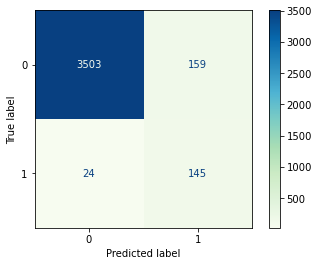

In [88]:
evaluation_report(cv_bag, X_train, y_train)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1198
           1       0.18      0.30      0.23        80

    accuracy                           0.87      1278
   macro avg       0.57      0.61      0.58      1278
weighted avg       0.90      0.87      0.89      1278



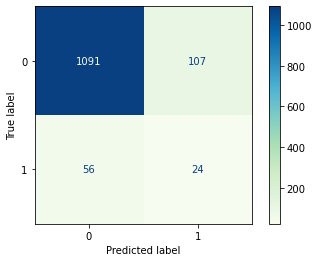

In [89]:
evaluation_report(cv_bag, X_test, y_test)

#### Model 10 

Check the edges of the best parameters in the last model and see how it performs

In [48]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced')))]

bag_pipe = imbpipeline(steps=steps)
#Fine tune parameters accordingly from previous models
params = {
    'bag__n_estimators': range(10,20,1),
    'bag__max_samples': [.8,.85,.9,.95],
    'bag__max_features': [18,19,20],
    'bag__base_estimator__max_depth':[2,3,4]
}
cv_bag = GridSearchCV(bag_pipe, param_grid=params, scoring='recall')
cv_bag.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

In [49]:
cv_bag.best_params_

{'bag__base_estimator__max_depth': 4,
 'bag__max_features': 18,
 'bag__max_samples': 0.85,
 'bag__n_estimators': 16}

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3662
           1       0.14      0.83      0.24       169

    accuracy                           0.77      3831
   macro avg       0.56      0.80      0.55      3831
weighted avg       0.95      0.77      0.83      3831



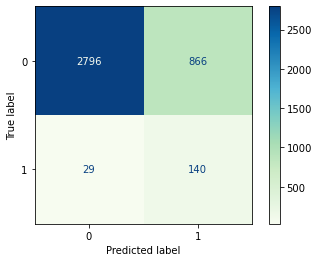

In [50]:
evaluation_report(cv_bag, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1198
           1       0.17      0.71      0.27        80

    accuracy                           0.76      1278
   macro avg       0.57      0.74      0.57      1278
weighted avg       0.93      0.76      0.82      1278



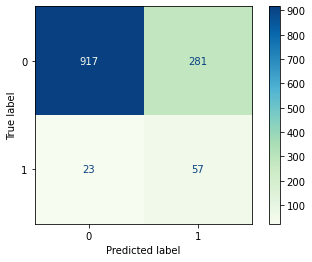

In [51]:
evaluation_report(cv_bag, X_test, y_test)

Close recall score between both sets but still on the lower end. We thought it be best to just try something else at this point. Since in boosting, each model learns from each other and improves on every model, we thought we would give it a shot. 

#### Model 11

Use XGBoost with a combination of GridSearchCV to find the best parameters for XGBoost. It'll pick the best features and hopefully provide the best model.

In [52]:
import xgboost

In [53]:
#find an initial xgboost model
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('xgb',xgboost.XGBClassifier())]

#Create the XGB Pipe
xgb_pipe = imbpipeline(steps=steps)
#Find initial parameters
params = {
    'xgb__max_depth': [3,5,7],
    'xgb__learning_rate': [.1,.01,.001,],
    'xgb__n_estimators': range(100,300,100)
}
#Run gridsearch
cv_xgb = GridSearchCV(xgb_pipe, param_grid=params, scoring='recall', n_jobs =-1 )

In [54]:
cv_xgb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      3662
           1       0.12      0.86      0.22       169

    accuracy                           0.72      3831
   macro avg       0.56      0.79      0.52      3831
weighted avg       0.95      0.72      0.80      3831



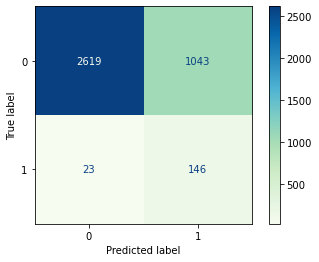

In [55]:
evaluation_report(cv_xgb, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1198
           1       0.16      0.82      0.26        80

    accuracy                           0.71      1278
   macro avg       0.57      0.76      0.54      1278
weighted avg       0.93      0.71      0.79      1278



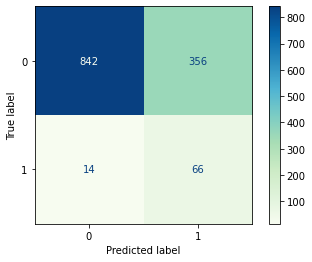

In [56]:
evaluation_report(cv_xgb, X_test, y_test)

The best parameters for this model was a learning rate of .001, a max depth of 3, and n_estimators of 200. The model produced a train and test recall score that was close but was still a little low. Lets try to fine tune it a little more using these best parameters and their edges

#### Model 12

Useing the best parameter and their edges from the previous model

In [57]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('xgb2',xgboost.XGBClassifier(
                                      max_depth = 2,))]


xgb_pipe2 = imbpipeline(steps=steps)
#Fine tune the parameters
params = {    
    'xgb2__learning_rate': [.0009,.001],
    'xgb2__max_depth': [2,3,4],
    'xgb2__n_estimators': [100,125,150,175]
}

cv_xgb2 = GridSearchCV(xgb_pipe2, param_grid=params, scoring='recall', n_jobs = -1,)


In [58]:
cv_xgb2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

In [59]:
cv_xgb2.best_params_

{'xgb2__learning_rate': 0.0009,
 'xgb2__max_depth': 2,
 'xgb2__n_estimators': 175}

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      3662
           1       0.11      0.85      0.20       169

    accuracy                           0.70      3831
   macro avg       0.55      0.77      0.51      3831
weighted avg       0.95      0.70      0.79      3831



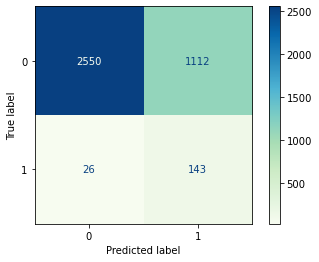

In [60]:
evaluation_report(cv_xgb2, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.84      0.26        80

    accuracy                           0.70      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.70      0.78      1278



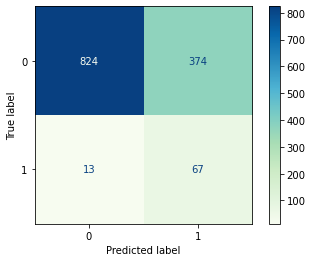

In [61]:
evaluation_report(cv_xgb2, X_test, y_test)

The best parameter for this model was a learning rate of .001, a max depth of 2, and an n_estimators of 175. Close in recall and high. Looks good!

#### Model 13

Try one more model with different parameters

In [62]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('xgb3',xgboost.XGBClassifier())]


xgb_pipe3 = imbpipeline(steps=steps)
#Fine tune params
params = {    
    'xgb3__learning_rate': [.0009],
    'xgb3__max_depth': [2],
    'xgb3__n_estimators': [100]
}

cv_xgb3 = GridSearchCV(xgb_pipe3, param_grid=params, scoring='recall', n_jobs = -1)

In [63]:
cv_xgb3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      3662
           1       0.11      0.85      0.20       169

    accuracy                           0.70      3831
   macro avg       0.55      0.77      0.51      3831
weighted avg       0.95      0.70      0.79      3831



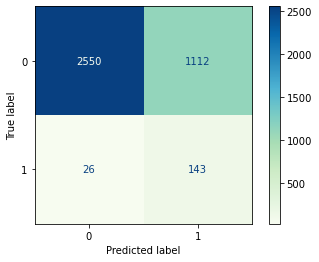

In [64]:
evaluation_report(cv_xgb3, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.84      0.26        80

    accuracy                           0.70      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.70      0.78      1278



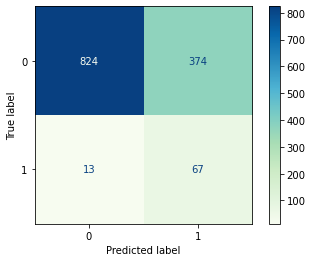

In [65]:
evaluation_report(cv_xgb3, X_test, y_test)

#### Best Model 

Pick the best model out of pipeline with XGBoost, max depth of 2, learning rate of .009 and n_estimators = 175

In [66]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('xgb3',xgboost.XGBClassifier(n_jobs = -1,
                                      max_depth = 2,
                                      learning_rate = 0.009,
                                      n_estimators = 175))]


xgb_pipe3 = imbpipeline(steps=steps)
xgb_pipe3.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_statu...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
               

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.82      0.26        80

    accuracy                           0.70      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.70      0.78      1278



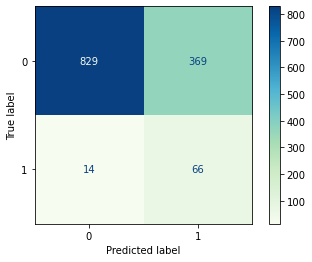

In [67]:
evaluation_report(xgb_pipe3, X_test, y_test)

In [68]:
#Get the feature importance from the model
xgb_pipe3.named_steps['xgb3'].feature_importances_

array([0.5454113 , 0.        , 0.        , 0.08788417, 0.0790147 ,
       0.        , 0.        , 0.06874038, 0.        , 0.        ,
       0.06690286, 0.        , 0.        , 0.0689496 , 0.        ,
       0.        , 0.        , 0.08309694], dtype=float32)

In [69]:
from xgboost import plot_importance
from matplotlib import pyplot

Plot the important features from the algorithm
    <br>- Manage to get the column names in order
    <br>- Plot the feature importance

In [70]:
X_train_nums

,age,avg_glucose_level
4000,24.00,105.26
3576,41.00,83.97
3032,52.00,87.51
1867,55.00,63.47
494,55.00,111.19
...,...,...
4427,61.00,144.14
466,61.00,170.05
3092,1.16,97.28
3773,38.00,93.93


In [71]:
ohe = OneHotEncoder(sparse = False, drop = 'first')
ohe.fit_transform(X_train_cat)

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
cat_cols = (ohe.get_feature_names(X_train.select_dtypes(exclude = 'float64').columns))


In [73]:
column_names = ['age','avg_glucose_level']
column_names = column_names+cat_cols.tolist()

In [74]:
xgb_pipe3.named_steps['xgb3'].get_booster().feature_names = column_names

In [75]:
from xgboost import plot_importance
from matplotlib import pyplot

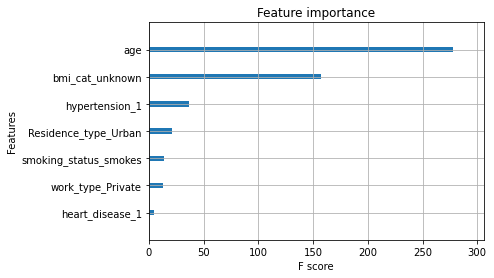

In [76]:
plot_importance(xgb_pipe3.named_steps['xgb3'], show_values = False)
pyplot.show()

So according to our model, the top two most important features seem to be Age and bmi_category_unknown. The features, as a whole, seem to be intuitively a good indicator of someone who might be at a high risk of stroke risk. 

Healthcare professionals should might want to use these features to help assess high risk patients. 

In [77]:
#Wanted to see the effect when adjusting threshold.

In [78]:
#Wanted to see the effect when adjusting threshold.
y_pred = (xgb_pipe3.predict_proba(X_test)[:,1] >= 0.4)

recall_score(y_test, y_pred)

0.9125

In [79]:
confusion_matrix(y_test, y_pred)

array([[679, 519],
       [  7,  73]])